## **NER for capstone EDA**

- Deployable ML model that performs NER with reasonable accuracy
Named Entiry Recognition for short text paragraphs geared toward identificatiobn of topics that imply technological or healthcare term

Dataset from Kaggle :
https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

Context:
Annotated Corpus for Named Entity Recognition using GMB(Groningen Meaning Bank) corpus for entity classification with enhanced and popular features by Natural Language Processing applied to the data set.

Tip: Use Pandas Dataframe to load dataset if using Python for convenience.

Content:
This is the extract from GMB corpus which is tagged, annotated and built specifically to train the classifier to predict named entities such as name, location, etc.

Number of tagged entities:

'O': 1146068', geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'per-ini': 60, 'org-leg': 60, 'per-ord': 38, 'tim-dom': 10, 'per-mid': 1, 'art-add': 1
Essential info about entities:

geo = Geographical Entity

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicator

art = Artifact

eve = Event

nat = Natural Phenomenon

Total Words Count = 1354149

Target Data Column: "tag"

Inspiration: This dataset is getting more interested because of more features added to the recent version of this dataset. Also, it helps to create a broad view of Feature Engineering with respect to this dataset.

Why this dataset is helpful or playful?

It might not sound so interested for earlier versions, but when you are able to pick intent and custom named entities from your own sentence with more features then, it is getting interested and helps you solve real business problems(like picking entities from Electronic Medical Records, etc)


Performance comparison:
https://github.com/amitkumarj441/CapsRoute_NER



# 1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
#Data analysis
import numpy as np
import pandas as pd
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats




#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#import statsmodels.api as sm

#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.feature_selection import RFE
#from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import confusion_matrix

In [ ]:
data = pd.read_csv('/content/drive/My Drive/FourthBrain/capstone/ner/data/ner_dataset.csv',encoding="latin1")
#https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner.csv
#data = pd.read_csv('https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/ner_dataset.csv', encoding="latin1")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
#make the first row as the heading, remove the first row and re-index the dataset
data.columns = data.iloc[0]

data = data[1:]

data.columns = ['Sentence #','Word','POS','Tag']

data = data.reset_index(drop=True)

data.tail()

,Sentence #,Word,POS,Tag
1048568,NaN,they,PRP,O
1048569,NaN,responded,VBD,O
1048570,NaN,to,TO,O
1048571,NaN,the,DT,O
1048572,NaN,attack,NN,O


In [ ]:
data.shape

(1048574, 4)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47958 non-null    object
 1   Word        1048574 non-null  object
 2   POS         1048574 non-null  object
 3   Tag         1048574 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [ ]:
data = data.fillna(method='ffill')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048573 entries, 0 to 1048572
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048551 non-null  object
 1   Word        1048573 non-null  object
 2   POS         1048573 non-null  object
 3   Tag         1048573 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [ ]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048563,Sentence: 47958,impact,NN,O
1048564,Sentence: 47958,.,.,O
1048565,Sentence: 47959,Indian,JJ,B-gpe
1048566,Sentence: 47959,forces,NNS,O
1048567,Sentence: 47959,said,VBD,O
1048568,Sentence: 47959,they,PRP,O
1048569,Sentence: 47959,responded,VBD,O
1048570,Sentence: 47959,to,TO,O
1048571,Sentence: 47959,the,DT,O
1048572,Sentence: 47959,attack,NN,O


In [ ]:
# find the number of words in the dataset
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

35178


In [ ]:
# get the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = getsentence(data)
sentences = getter.sentences

print(sentences[1])

[('Helicopter', 'NN', 'O'), ('gunships', 'NNS', 'O'), ('Saturday', 'NNP', 'B-tim'), ('pounded', 'VBD', 'O'), ('militant', 'JJ', 'O'), ('hideouts', 'NNS', 'O'), ('in', 'IN', 'O'), ('the', 'DT', 'O'), ('Orakzai', 'NNP', 'B-geo'), ('tribal', 'JJ', 'O'), ('region', 'NN', 'O'), (',', ',', 'O'), ('where', 'WRB', 'O'), ('many', 'JJ', 'O'), ('Taliban', 'NNP', 'B-org'), ('militants', 'NNS', 'O'), ('are', 'VBP', 'O'), ('believed', 'VBN', 'O'), ('to', 'TO', 'O'), ('have', 'VB', 'O'), ('fled', 'VBN', 'O'), ('to', 'TO', 'O'), ('avoid', 'VB', 'O'), ('an', 'DT', 'O'), ('earlier', 'JJR', 'O'), ('military', 'JJ', 'O'), ('offensive', 'NN', 'O'), ('in', 'IN', 'O'), ('nearby', 'JJ', 'O'), ('South', 'NNP', 'B-geo'), ('Waziristan', 'NNP', 'I-geo'), ('.', '.', 'O')]


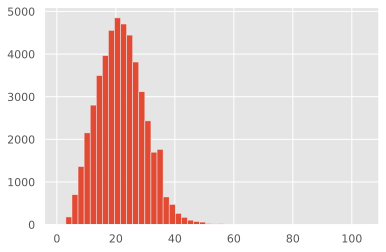

In [ ]:
#visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
#find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 104


In [ ]:
#Words tagged as B-org
data.loc[data['Tag'] == 'B-org', 'Word'].head()

95             Labor
152    International
213             IAEA
232         European
246             U.N.
Name: Word, dtype: object

In [ ]:
#Words tagged as I-org
data.loc[data['Tag'] == 'I-org', 'Word'].head()

96      Party
153    Atomic
154    Energy
155    Agency
233     Union
Name: Word, dtype: object

In [ ]:
#Words tagged as B-per
data.loc[data['Tag'] == 'B-per', 'Word'].head()

40          Bush
268    President
329       Thomas
441    President
963      Prophet
Name: Word, dtype: object

In [ ]:
#Words tagged as I-per
data.loc[data['Tag'] == 'I-per', 'Word'].head()

269        Mahmoud
270    Ahmadinejad
330        Horbach
442      Abdullahi
443          Yusuf
Name: Word, dtype: object

In [ ]:
#Words tagged as B-geo
data.loc[data['Tag'] == 'B-geo', 'Word'].head()

4        London
10         Iraq
63         Hyde
92      Britain
104    Brighton
Name: Word, dtype: object

In [ ]:
#Words tagged as I-geo
data.loc[data['Tag'] == 'I-geo', 'Word'].head()

64      Park
345    State
348    State
379    Delta
559     Arab
Name: Word, dtype: object

In [ ]:
#Words tagged as I-geo
data.loc[data['Tag'] == 'O', 'Word'].head()

0    demonstrators
1             have
2          marched
3          through
5               to
Name: Word, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


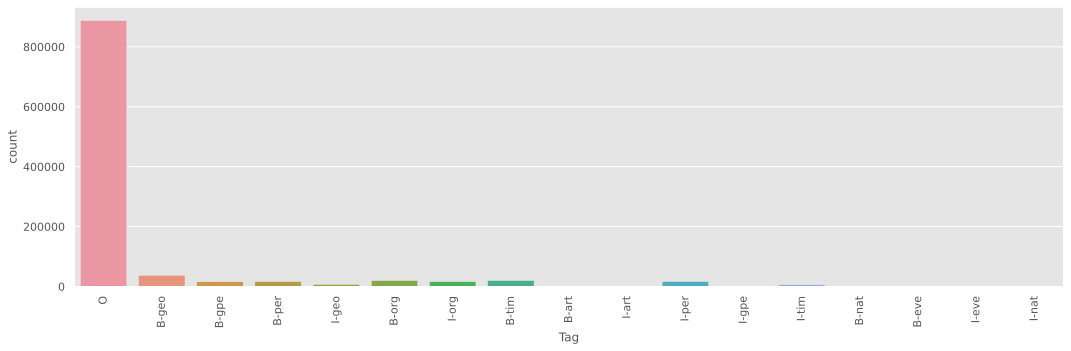

In [ ]:
#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


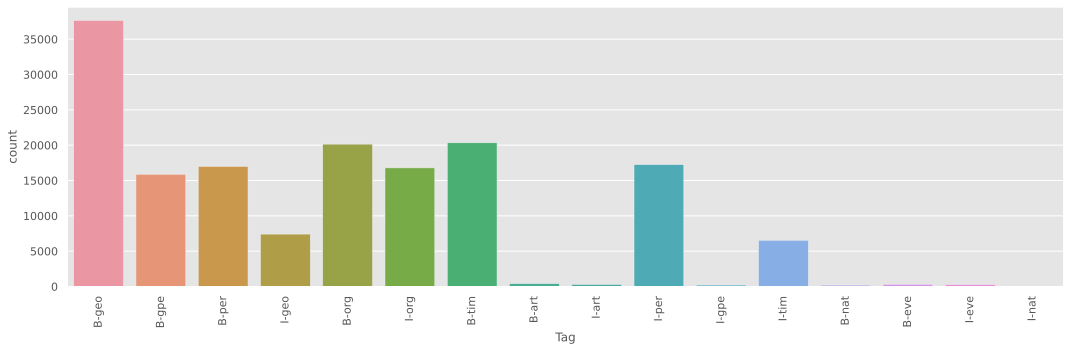

In [ ]:
#Words distribution across Tags without O tag
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


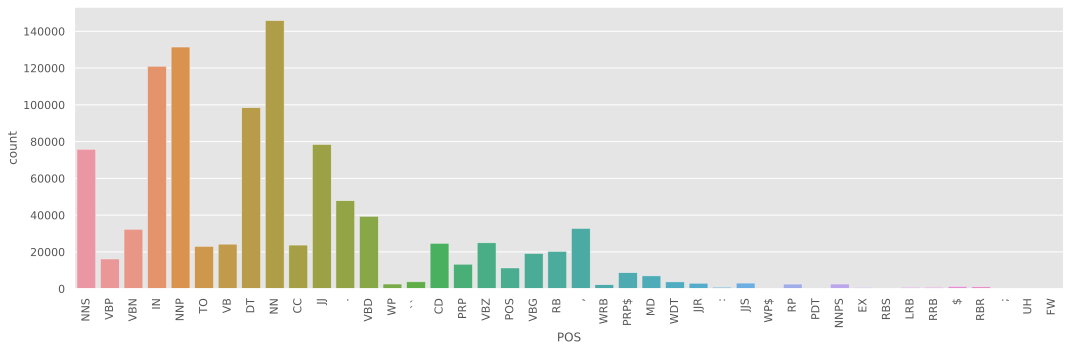

In [ ]:
#Words distribution across POS
plt.figure(figsize=(15, 5))
ax = sns.countplot('POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()